# Part 2: Implementing a simple Convolutional classifier

**Question 7**: Use the dataloaders to load both the train and the test set into large tensors:
one for the instances, one for the labels. Split the training data into 50 000 training instances
and 10 000 validation instances. Then write a training loop that loops over batches of 16
instances at a time.

Notes:

● Note that the range() function in python can be called with three arguments, to iterate
in large steps.

● It's useful to know that the slice syntax is forgiving if the second argument is out of
bounds. If you have an array with 32 elements then arr[30:36], will just give you
the last two elements without complaining.

● If you have a GPU, make sure not to load these data tensors into GPU memory. It's
better to load each batch into the GPU memory as you loop over the data

We'll use the following network:


| Input size | Layer / Operation | 
:----------:|:-----------------:|
| (batch, 1, 28, 28) | nn.Conv2d | 
| | kernel size 3x3, stride 1, padding 1, 16 output channels | 
| (batch, 16, 28, 28) | ReLU | 
| (batch, 16, 28, 28) | 2x2 Max pool | 
| (batch, 16, 14, 14) | nn.Conv2D | 
| | kernel size 3x3, stride 1, padding 1, 32 output channels |
| (batch, 32, 14, 14) | ReLU | 
| (batch, 32, 14, 14) | 2x2 Max pool |
| (batch, 32, 7, 7) | nn.Conv2D |
| | kernel size 3x3, stride 1, padding 1, 64 output channels |
| (batch, 64, 7, 7) | ReLU |
| (batch, 64, 7, 7) | 2x2 Max pool |
| (batch, 64, 3, 3) | Reshape to flatten the image |
| (batch, 64 * 3 * 3) | Linear layer | 
| (batch, 10) | |


Use cross-entropy as the loss function, and Adam as the optimizer. Most of this was covered
in the PyTorch 60 minute blitz.

In [61]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision import transforms




BATCH_SIZE = 64
EPOCHS = 10

train = datasets.MNIST('MNIST_data/',
                       download=True,
                       train=True,
                       transform=ToTensor())
trainloader = torch.utils.data.DataLoader(train, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=2)

test = datasets.MNIST('MNIST_data/',
                    download=True,
                    train=False,
                    transform=ToTensor())

testloader = torch.utils.data.DataLoader(test,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2)

# CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [62]:

def Q7(trainloader: torch.utils.data.DataLoader, 
       testloader: torch.utils.data.DataLoader) -> tuple:
    '''
    Returns a tuple of tensors containing the training data, training labels,
    '''
    train_data = torch.tensor([])
    train_labels = torch.tensor([])
    test_data = torch.tensor([])
    test_labels = torch.tensor([])

    # Load data into tensors
    for data, labels in trainloader:
        train_data = torch.cat((train_data, data), 0)
        train_labels = torch.cat((train_labels, labels), 0)

    for data, labels in testloader:
        test_data = torch.cat((test_data, data), 0)
        test_labels = torch.cat((test_labels, labels), 0)

    # Split training data into training and validation sets
    train_data, val_data = train_data[:50000], train_data[50000:]
    train_labels, val_labels = train_labels[:50000], train_labels[50000:]

    return (train_data, train_labels, val_data, val_labels, test_data, test_labels)

def training_loop(n_epochs: int, 
                  optimizer: torch.optim.Adam, 
                  model: nn.Module, 
                  criterion: nn.CrossEntropyLoss, 
                  train_data: torch.Tensor, 
                  train_labels: torch.Tensor, 
                  val_data: torch.Tensor, 
                  val_labels: torch.Tensor) -> tuple:
    '''
    Returns a tuple of tensors containing the training loss, validation loss, 
    training accuracy, and validation accuracy for each epoch.
    '''
    train_loss = torch.tensor([])
    val_loss = torch.tensor([])
    train_acc = torch.tensor([])
    val_acc = torch.tensor([])

    for epoch in range(n_epochs):
        model.train()
        print(f"{'*'*10} Epoch {epoch+1}/{n_epochs} {'*'*10}")
        running_loss = 0.0
        running_acc = 0.0
        for i in range(0, len(train_data), 16):
            batch_data = train_data[i:i+16].to(device)
            batch_labels = train_labels[i:i+16].long().to(device)
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_acc += (predicted == batch_labels).sum().item()
        train_loss = torch.cat((train_loss, torch.tensor([running_loss])), 0)
        train_acc = torch.cat((train_acc, torch.tensor([running_acc / len(train_data)])), 0)
        print(f"Training loss: {running_loss}")
        print(f"Training accuracy: {running_acc / len(train_data)} \n")

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0
            for i in range(0, len(val_data), 16):
                batch_data = val_data[i:i+16].to(device)
                batch_labels = val_labels[i:i+16].long().to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                running_acc += (predicted == batch_labels).sum().item()
            val_loss = torch.cat((val_loss, torch.tensor([running_loss])), 0)
            val_acc = torch.cat((val_acc, torch.tensor([running_acc / len(val_data)])), 0)
            print(f"Validation loss: {running_loss}")
            print(f"Validation accuracy: {running_acc / len(val_data)} \n")
    return (train_loss, val_loss, train_acc, val_acc)

**Question 8**: Build this network and tune the hyperparameters until you get a good baseline
performance you are happy with. You should be able to get at least 95% accuracy. If training
takes too long, you can reduce the number of channels in each layer.
In the lectures, we briefly discussed the idea of data augmentation. This is easily added to
our network.

In [63]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear_layer = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = self.linear_layer(x)
        return x

In [64]:
model = ConvNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model)

data = Q7(trainloader, testloader)

(train_data,
train_labels,
val_data,
val_labels,
test_data,
test_labels) = data

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)


In [65]:
results = training_loop(EPOCHS, optimizer, model, criterion, train_data, train_labels, val_data, val_labels)

********** Epoch 1/10 **********
Training loss: 506.8470366988622
Training accuracy: 0.95008 

Validation loss: 40.71202517001075
Validation accuracy: 0.9798 

********** Epoch 2/10 **********
Training loss: 163.76575179126667
Training accuracy: 0.98378 

Validation loss: 28.73783942166483
Validation accuracy: 0.9871 

********** Epoch 3/10 **********
Training loss: 114.80216891241525
Training accuracy: 0.9886 

Validation loss: 32.18032888952075
Validation accuracy: 0.9853 

********** Epoch 4/10 **********
Training loss: 84.74502557474898
Training accuracy: 0.99162 

Validation loss: 35.00974216520444
Validation accuracy: 0.9858 

********** Epoch 5/10 **********
Training loss: 65.92435530301475
Training accuracy: 0.99318 

Validation loss: 27.371787128547794
Validation accuracy: 0.9878 

********** Epoch 6/10 **********
Training loss: 54.19795556051386
Training accuracy: 0.99436 

Validation loss: 37.741094794367825
Validation accuracy: 0.9851 

********** Epoch 7/10 **********
Trai

In [66]:
def test(model: nn.Module,
        test_data: torch.Tensor,
        test_labels: torch.Tensor) -> None:
    
    model.eval()
    # test data
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i in range(0, len(test_data), 16):
            batch_data = test_data[i:i+16].to(device)
            batch_labels = test_labels[i:i+16].long().to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_acc += (predicted == batch_labels).sum().item()
        print(f"Test loss: {running_loss}")
        print(f"Test accuracy: {running_acc / len(test_data)} \n")

In [67]:
test(model, test_data, test_labels)

Test loss: 23.07802283495569
Test accuracy: 0.9901 



In [68]:
import matplotlib.pyplot as plt
import numpy as np
# FIRST TRY

def plot_results(results: tuple) -> None:
    
    results = [item.to('cpu') for item in results]
    (train_loss, val_loss, train_acc, val_acc) = results

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    epochs = np.arange(1, EPOCHS+1)

    axs[0].plot(train_loss, label='Training Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_xticks(epochs)
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_acc, label='Training Accuracy')
    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_xticks(epochs)
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

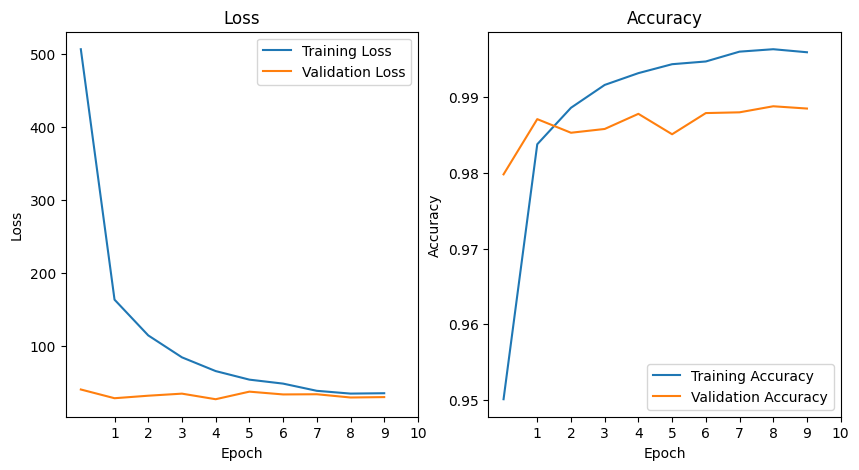

In [69]:
plot_results(results)

**Question 9**: Add some data augmentations when creating the dataset for the training set.
Why do we only augment the training data? Play around with the augmentations available in
torchvision. Try to get better performance than the baseline. Once you are happy with your
choice of augmentations, run both the baseline and the augmented version on the test set
and report the accuracies in your report.

Notes:

● When we use data augmentation, using the data loaders to load the whole data into
big tensors (as we did in Question 7) creates a problem, because this means that the
transformations are only applied once per instance in the training set. Instead, we
would like to iterate multiple times over the dataset, and each time get different
transformations. You can achieve this by using the data loaders to iterate through the
data (as opposed to using the big tensors from Question 7). Make sure to create a
validation set first by applying the random_split function to the training set:

https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

○ Apply this to the dataset object before passing it to the dataloader.

In [70]:
from torchvision import datasets, transforms
import torch

def data_augmented(BATCH_SIZE: int) -> tuple:

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    train = datasets.MNIST('MNIST_data/',
                           download=True,
                           train=True,
                           transform=transform)

    test = datasets.MNIST('MNIST_data/',
                          download=True,
                          train=False,
                          transform=transforms.ToTensor())


    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train, [train_size, val_size])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader


def Q7_new(trainloader: torch.utils.data.DataLoader, 
       valloader: torch.utils.data.DataLoader,
       testloader: torch.utils.data.DataLoader) -> tuple:
    '''
    Returns a tuple of tensors containing the training data, training labels,
    '''
    train_data = torch.tensor([])
    train_labels = torch.tensor([])
    val_data = torch.tensor([])
    val_labels = torch.tensor([])
    test_data = torch.tensor([])
    test_labels = torch.tensor([])

    # Load data into tensors
    for data, labels in trainloader:
        train_data = torch.cat((train_data, data), 0)
        train_labels = torch.cat((train_labels, labels), 0)

    for data, labels in testloader:
        test_data = torch.cat((test_data, data), 0)
        test_labels = torch.cat((test_labels, labels), 0)

    for data, labels in valloader:
        val_data = torch.cat((val_data, data), 0)
        val_labels = torch.cat((val_labels, labels), 0)

    return (train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [71]:
trainloader, valloader, testloader = data_augmented(BATCH_SIZE)
train_data, train_labels, val_data, val_labels, test_data, test_labels = Q7_new(trainloader, valloader, testloader)

In [72]:
model_new = ConvNN()
model_new.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model_new)

results_new = training_loop(EPOCHS, optimizer, model_new, criterion, train_data, train_labels, val_data, val_labels)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
********** Epoch 1/10 **********
Training loss: 986.9614811493084
Training accuracy: 0.8933125 

Validation loss: 124.20821576844901
Validation accuracy: 0.94775 

********** Epoch 2/10 **********
Training loss: 384.6247423022287
Training accuracy: 0.9597083333333334 

Validation loss: 86.27732552983798
Validation accuracy: 0.96475 

********** Epoch 3/10 **********
Training loss: 273.02517386842374
Training accuracy: 0.9712291666666667 

Validation loss: 84.03164400358219
Validation accuracy: 0.96575 

********** Epoch 4/10 **********
Training loss: 207.13335530730546
Training accuracy: 0.97829166

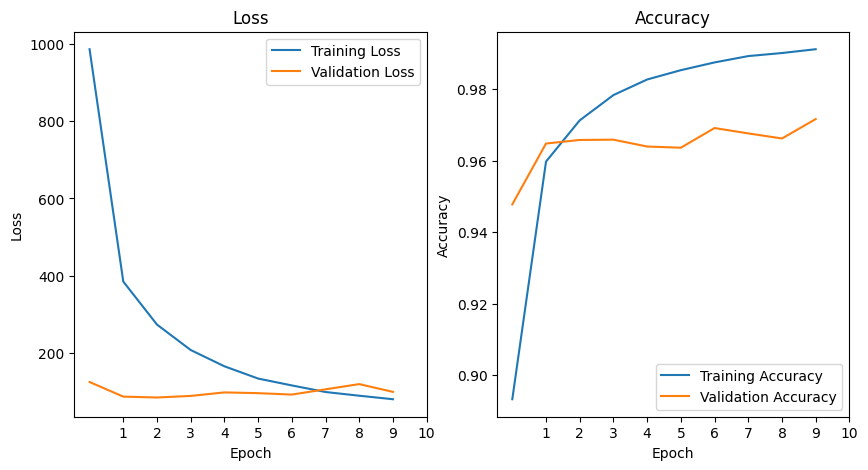

In [73]:
plot_results(results_new)

In [74]:
test(model_new, test_data, test_labels)

Test loss: 57.658936310270164
Test accuracy: 0.978 

